In [1]:
# 1
# ++++ IMPORTS ++++ #

get_ipython().run_line_magic('matplotlib', 'notebook')
import numpy as np
from numpy import mat, zeros, newaxis
import matplotlib.pyplot as plt

In [2]:
# 2
# ++++ MOVEMENT METHODS ++++ #

# Executed one Euler-Maruyama step with potential drift, noise variance sigma, starting value y0 and time step deltaT
def emstep(drift,sigma,y0,deltaT = 0.01):
    n = len(y0)
    noise = np.random.normal(loc=0.0,scale=1.0,size=n)
    diffusion = lambda x: sigma
    y = y0 + drift(y0)*deltaT + diffusion(y0)*noise*np.sqrt(deltaT)
    return y


# This method returns a suitability landscape as a function that depends on the position parameter y
def suitabilitylandscape(index = 0):
    if(index == 0):
        V = lambda y: 10*((y[0]**2-1)**2+y[1]**2)**0.05
        return V
    elif(index == 1):
        im = plt.imread('landmap_matlaberzeugt1.png')
        V = lambda y: 10*im[np.min([np.int(y[1]*im.shape[0]/10),im.shape[0]-1]),np.min([np.int(y[0]*im.shape[1]/10),im.shape[1]-1]),1]
        return V
    elif(index == 2):
        V = lambda y: y[0]
        return V
    elif(index == 3):
        V = lambda y: 0 # Write your own potential here
        return V

# This method designs a matrix that contains function values of a function V (here: made for suitability landscapes) in an equidistant grid between limits = [xmin,xmax,ymin,ymax]
def suitabilitylandscapematrix(V,limits,nx=100,ny=100):
    [xmin,xmax,ymin,ymax] = limits
    xvec = np.linspace(xmin,xmax,nx)
    yvec = np.linspace(ymin,ymax,ny)
    A = zeros((nx,ny))
    for x in range(nx):
        for y in range(ny):
            A[x,y] = V([yvec[y],xvec[x]])
    return A


# Calculates the gradient of a function V (here: made for suitability landscapes) at the point x
def suitabilitylandscapegradient(x,V,deltaX = 0.1):
    Vx = V(x)
    n = len(x)
    grad = np.zeros(n)
    for i in range(n):
        unitvec = np.zeros(n)
        unitvec[i] = deltaX
        grad[i] = (V(x+unitvec) - Vx) / deltaX
    return grad


# Gives the value of the repulsion-attraction potential of a set of agent positions X evaluated at the point x. 
def repulsionattraction(x,X,distequilibrium = 0.2):
    N = len(X[0,:])
    s = 0
    U = lambda x: (1 - np.exp(-(np.linalg.norm(x)-distequilibrium)))**2 # repulsion-attraction potential function
    for j in range(0,N):
        s += U(X[:,j]-x)
    return s


# Gives the gradient of the repulsion-attraction potential at a point x
def repulsionattractiongradient(x,X,deltaX = 0.1):
    RAx = repulsionattraction(x,X)
    n = len(x)
    grad = np.zeros(n)
    for i in range(n):
        unitvec = np.zeros(n)
        unitvec[i] = deltaX
        grad[i] = (repulsionattraction(x+unitvec,X) - RAx) / deltaX
    return grad

In [3]:
# 3
# ++++ INFECTION METHODS ++++ #

# For a matrix X with n columns, this method computes a symmetric n x n matrix A for which the ij-entry denotes the Euclidean distance between the i-th and j-th columns of X. In our case, it computes
# the distances between all agents
def distancematrix(X):
    return np.sum((X[:, np.newaxis, :] - X[np.newaxis, :, :]) ** 2, axis = -1)

# This method determines the interaction rate for agent i as the number of other agents whose distance to agent i is smaller than r
def determineInteractionRate(i,A,I,r):
    return (A[i,(I==1)] < r).sum()


# Randomly outputs either 1 or 0 based on the value of the inputted infectionrate and parameter gamma. If infstate is already 1, then it outputs 1 in any case.
def infectAtRandom(infectionstate,interactionrate,gamma = 1):
    a = np.random.uniform()
    if(infectionstate == 1 or a < 1 - np.exp(-gamma*interactionrate)):
        return 1
    else:
        return 0


In [4]:
# 4
# ++++ PLOT METHOD ++++ #

def plotMovie(X,I,T,V,limits = [-2,2,-2,2]):
    fig = plt.figure()
    ax1 = fig.add_subplot(1,1,1)
    # Plot
    #limits = [0,10,0,10]
    [xmin,xmax,ymin,ymax] = limits
    
    # Create matrix with values of suitability landscape
    L = suitabilitylandscapematrix(V,limits)
    # plot the suitability landscape
    plt.imshow(L, cmap='jet', interpolation='nearest', extent=[xmin,xmax,ymin,ymax],alpha = 0.2)
    #plt.show()
    # Set bounds of plot
    plt.xlim((xmin,xmax))
    plt.ylim((ymin,ymax))
    line0, = ax1.plot(0,0,'bo') # plot of non-infected agents
    line1, = ax1.plot(0,0,'ro') # plot of infected agents
    fig.canvas.draw()
    for t in range(T):
        # Indices of infected and non-infected agents
        infected = (I[t,:] == 1)
        noninfected = (I[t,:] == 0)
        # plot infected agents (in red)
        line1.set_xdata(X[t,infected,0])
        line1.set_ydata(X[t,infected,1])
        # plot non-infected agents (in blue)
        line0.set_xdata(X[t,noninfected,0])
        line0.set_ydata(X[t,noninfected,1])
        fig.canvas.draw()
        # Wait for 0.25seconds so that a movie is created
        plt.pause(0.25)


In [5]:
# 5
# +++++ BEGIN OF MAIN FRAMEWORK +++++ #

In [39]:
# 6 
# Basic setting
n = 2 # dimension
N = 10 # number of agents
T = 200 # number of time steps

In [40]:
# 7
# Position and Infection state initialization
X = np.zeros((T,N,n)) # array for positions of agents
X[0,:,:] = np.random.multivariate_normal(np.array([-1,0]).T, np.diag([.2,.2]), N) # initial positions
I = np.ones((T,N)) # array for infection states of agents
I[0,:] = np.round(np.random.uniform(0, 1, N)) # initial infection states

In [41]:
# 8
# Choose the Suitability Landscape
######
doublewell = 0
landmap = 1
linear = 2
individual = 3
V = suitabilitylandscape(doublewell) # choose suitability landscape

# radius for the determination of the infection rate
radius = 0.2 

In [42]:
# 9
# Parameters for the numerical scheme
deltaT = 0.01 # time step size
sigma = 0.02 # variance of noise in movement SDE

In [43]:
# 10
for t in range(T-1): # for all time steps..
    A_distance = distancematrix(X[t,:,:]) # distance matrix
    for i in range(N): # for all agents i...
        
        ############################
        # Define the potential by the sum of the two individual potentials: The suitability landscape and the repulsion-attraction potential
        gradpotential = lambda x: -(suitabilitylandscapegradient(x,V) + repulsionattractiongradient(x,X[t,list(range(N)).remove(i),:].T))
        # EM-Step
        X[t+1,i,:] = emstep(gradpotential,sigma,X[t,i,:],deltaT)
        # Possible infection
        infectionrate = determineInteractionRate(i,A_distance,I[t,:],radius)
        I[t+1,i] = infectAtRandom(I[t,i],infectionrate) # possibly infect agent i with probability based on infection rate
        ############################



<IPython.core.display.Javascript object>


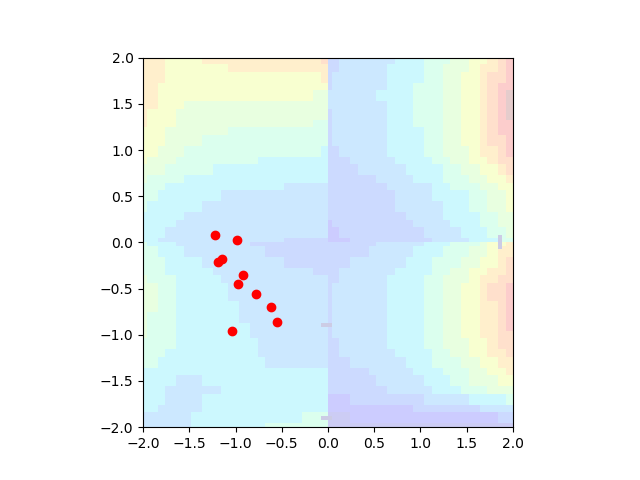

KeyboardInterrupt: 

In [44]:
# 11
# PLOT
plotMovie(X, I, T, V)